In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("data/combined_expression.csv")
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,2,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,3,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,3,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,3,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,3,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data.shape

(541, 16384)

In [4]:
selected_genes = pd.read_csv('cleaned/boruta-0.05.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [5]:
data['cluster'].replace([1, 2, 3],[0, 1, 0],inplace=True)

In [6]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [393]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# 4 Hidden Layers (with batch normalization)

In [7]:
def hidden4(optimizer='rmsprop',init='glorot_uniform', dropout=0.1):
    model = Sequential()
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*0.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*0.25, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# parameters selected from previous gridsearch
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adam',init='normal')
kfold = KFold(n_splits=3, shuffle=True)
results = cross_val_score(model4, X_train, y_train, cv=kfold)
print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
401/401 [==============================] - 1s 2ms/sample - loss: 0.4500 - acc: 0.8105
Epoch 2/50
401/401 [==============================] - 0s 190us/sample - loss: 0.2732 - acc: 0.8778
Epoch 3/50
401/401 [==============================] - 0s 190us/sample - loss: 0.2317 - acc: 0.9127
Epoch 4/50
401/401 [==============================] - 0s 167us/sample - loss: 0.1825 - acc: 0.9451
Epoch 5/50
401/401 [==============================] - 0s 171us/sample - loss: 0.1319 - acc: 0.9601
Epoch 6/50
401/401 [==============================] - 0s 182us/sample - loss: 0.1155 - acc: 0.9651
Epoch 7/50
401/401 [==============================] - 0s 191us/sample - loss: 0.0994 - acc: 0.9701
Epoch 8/50
401/401 [==============================] - 0s 176us/sample - loss: 0.0926 - acc: 0.970

In [11]:
history4 = model4.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred4 = model4.predict(X_test)

Train on 602 samples, validate on 109 samples
Epoch 1/50
602/602 [==============================] - 1s 2ms/sample - loss: 0.4524 - acc: 0.8140 - val_loss: 0.5681 - val_acc: 0.8349
Epoch 2/50
602/602 [==============================] - 0s 219us/sample - loss: 0.2787 - acc: 0.8870 - val_loss: 0.4682 - val_acc: 0.8440
Epoch 3/50
602/602 [==============================] - 0s 213us/sample - loss: 0.2060 - acc: 0.9186 - val_loss: 0.4220 - val_acc: 0.8716
Epoch 4/50
602/602 [==============================] - 0s 206us/sample - loss: 0.1701 - acc: 0.9435 - val_loss: 0.3944 - val_acc: 0.8807
Epoch 5/50
602/602 [==============================] - 0s 204us/sample - loss: 0.1612 - acc: 0.9419 - val_loss: 0.3863 - val_acc: 0.8899
Epoch 6/50
602/602 [==============================] - 0s 242us/sample - loss: 0.1296 - acc: 0.9535 - val_loss: 0.3607 - val_acc: 0.8807
Epoch 7/50
602/602 [==============================] - 0s 196us/sample - loss: 0.1091 - acc: 0.9635 - val_loss: 0.3667 - val_acc: 0.8532
Epoc

In [12]:
print(classification_report(y_test, y_pred4))

precision    recall  f1-score   support

           0       0.89      0.84      0.87        70
           1       0.74      0.82      0.78        39

    accuracy                           0.83       109
   macro avg       0.82      0.83      0.82       109
weighted avg       0.84      0.83      0.84       109



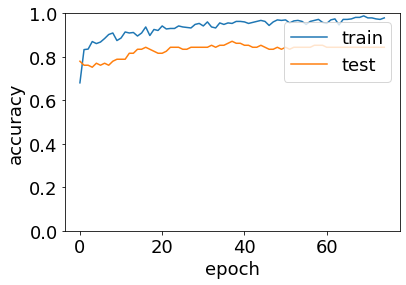

In [398]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.show()

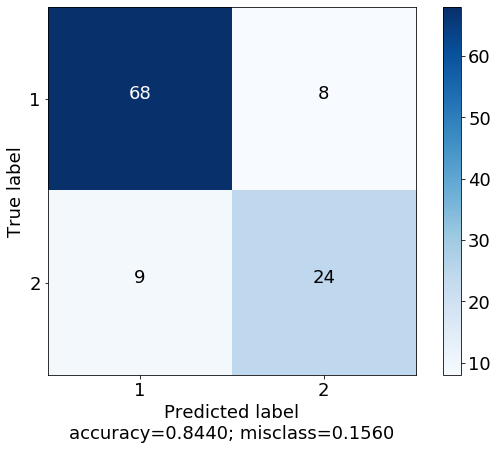

In [399]:
cm = confusion_matrix(y_test, y_pred4)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [114]:
model4.model.save('models/hidden4.h5')

# 3 Hidden Layers

In [356]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(BatchNormalization())
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(BatchNormalization())
    model.add(Dense((hidden_layers*1), activation='relu'))
    model.add(Dropout(dropout))

    model.add(BatchNormalization())
    model.add(Dense((hidden_layers*0.5), activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [357]:
# parameters selected from previous gridsearch
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=64, optimizer='adam', init='normal')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [358]:
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred3 = model3.predict(X_test)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 5s 12ms/sample - loss: 0.7487 - accuracy: 0.5741 - val_loss: 0.6501 - val_accuracy: 0.6422
Epoch 2/50
432/432 [==============================] - 0s 701us/sample - loss: 0.4547 - accuracy: 0.8056 - val_loss: 0.6520 - val_accuracy: 0.6422
Epoch 3/50
432/432 [==============================] - 0s 695us/sample - loss: 0.3414 - accuracy: 0.8981 - val_loss: 0.6787 - val_accuracy: 0.6422
Epoch 4/50
432/432 [==============================] - 0s 690us/sample - loss: 0.2979 - accuracy: 0.8843 - val_loss: 0.7150 - val_accuracy: 0.6422
Epoch 5/50
432/432 [==============================] - 0s 679us/sample - loss: 0.2697 - accuracy: 0.8935 - val_loss: 0.7387 - val_accuracy: 0.6422
Epoch 6/50
432/432 [==============================] - 0s 674us/sample - loss: 0.2832 - accuracy: 0.8843 - val_loss: 0.7283 - val_accuracy: 0.6422
Epoch 7/50
432/432 [==============================] - 0s 691us/sample - loss: 0

In [359]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88        71
           2       0.81      0.68      0.74        38

    accuracy                           0.83       109
   macro avg       0.83      0.80      0.81       109
weighted avg       0.83      0.83      0.83       109



In [360]:
print(confusion_matrix(y_test, y_pred3))

[[65  6]
 [12 26]]


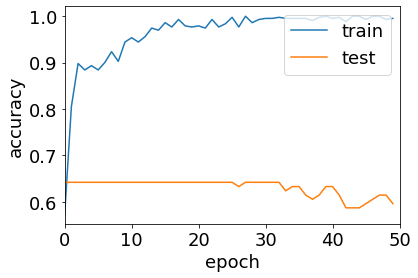

In [361]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

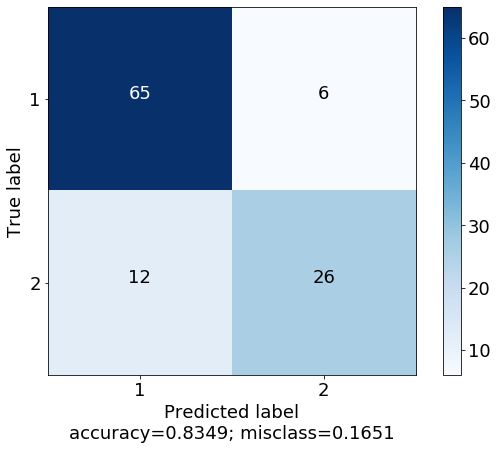

In [362]:
cm = confusion_matrix(y_test, y_pred3)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2'], title='', normalize=False)

In [ ]:
model3.model.save('models/hidden3.h5')

# 2 Hidden Layers

In [147]:
def hidden2(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense((hidden_layers), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(3, activation='softmax'))
    # compiling
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [148]:
# parameters selected from previous gridsearch
model2 = KerasClassifier(build_fn=hidden2, epochs=75, batch_size=64, optimizer='Adagrad',init='uniform')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [149]:
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred2 = model2.predict(X_test)

Train on 432 samples, validate on 109 samples
Epoch 1/75
432/432 [==============================] - 2s 4ms/sample - loss: 1.3817 - accuracy: 0.4421 - val_loss: 7.7001 - val_accuracy: 0.6422
Epoch 2/75
432/432 [==============================] - 0s 286us/sample - loss: 1.1376 - accuracy: 0.5509 - val_loss: 7.7828 - val_accuracy: 0.3945
Epoch 3/75
432/432 [==============================] - 0s 280us/sample - loss: 0.9973 - accuracy: 0.6134 - val_loss: 7.8597 - val_accuracy: 0.2936
Epoch 4/75
432/432 [==============================] - 0s 283us/sample - loss: 0.8847 - accuracy: 0.6481 - val_loss: 7.9480 - val_accuracy: 0.2569
Epoch 5/75
432/432 [==============================] - 0s 282us/sample - loss: 0.8756 - accuracy: 0.6296 - val_loss: 7.9803 - val_accuracy: 0.2018
Epoch 6/75
432/432 [==============================] - 0s 308us/sample - loss: 0.8004 - accuracy: 0.6968 - val_loss: 8.0103 - val_accuracy: 0.1927
Epoch 7/75
432/432 [==============================] - 0s 284us/sample - loss: 0.

432/432 [==============================] - 0s 308us/sample - loss: 0.5445 - accuracy: 0.7593 - val_loss: 10.9651 - val_accuracy: 0.2752
Epoch 57/75
432/432 [==============================] - 0s 306us/sample - loss: 0.5395 - accuracy: 0.7824 - val_loss: 11.0864 - val_accuracy: 0.2936
Epoch 58/75
432/432 [==============================] - 0s 320us/sample - loss: 0.5439 - accuracy: 0.7824 - val_loss: 11.1919 - val_accuracy: 0.2844
Epoch 59/75
432/432 [==============================] - 0s 323us/sample - loss: 0.5357 - accuracy: 0.7593 - val_loss: 11.2324 - val_accuracy: 0.2936
Epoch 60/75
432/432 [==============================] - 0s 328us/sample - loss: 0.5388 - accuracy: 0.7731 - val_loss: 11.2644 - val_accuracy: 0.2936
Epoch 61/75
432/432 [==============================] - 0s 331us/sample - loss: 0.5040 - accuracy: 0.7963 - val_loss: 11.3636 - val_accuracy: 0.2844
Epoch 62/75
432/432 [==============================] - 0s 333us/sample - loss: 0.5461 - accuracy: 0.7824 - val_loss: 11.4045

In [150]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.50      0.56      0.53        27
           2       0.68      0.76      0.72        25
           3       0.78      0.70      0.74        57

    accuracy                           0.68       109
   macro avg       0.65      0.67      0.66       109
weighted avg       0.69      0.68      0.68       109



In [151]:
print(confusion_matrix(y_test, y_pred2))

[[15  3  9]
 [ 4 19  2]
 [11  6 40]]


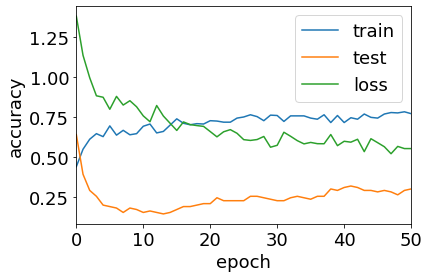

In [152]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.xlim(0, 50)
plt.show()

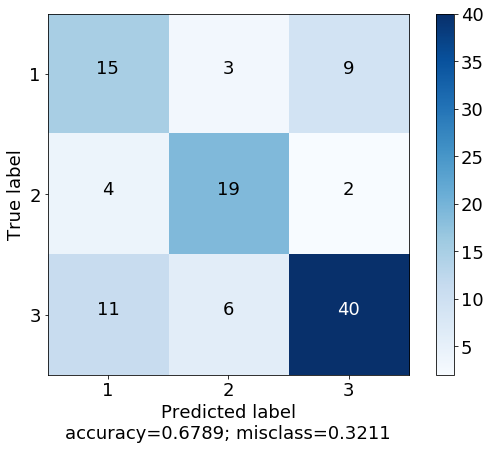

In [153]:
cm = confusion_matrix(y_test, y_pred2)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2', '3'], title='', normalize=False)

In [ ]:
model2.model.save('models/hidden2.h5')

# 1 Hidden Layer

In [ ]:
def hidden1(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*1.5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='softmax'))
    # compiling
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# parameters selected from previous gridsearch
model1 = KerasClassifier(build_fn=hidden1, epochs=50, batch_size=16, optimizer='Adam',init='uniform')
# kfold = KFold(n_splits=3, shuffle=True)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print("Baseline Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred1 = model1.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred1))

In [ ]:
print(confusion_matrix(y_test, y_pred1))

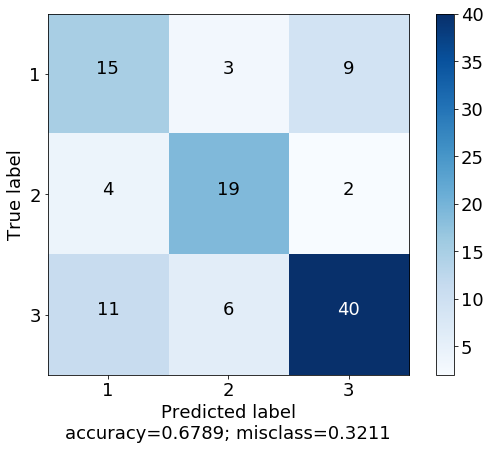

In [153]:
cm = confusion_matrix(y_test, y_pred1)
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm, ['1', '2', '3'], title='', normalize=False)

In [ ]:
model1.model.save('models/hidden1.h5')